In [1]:
# standard
import pandas as pd
import numpy as np
import random
import os
from collections import Counter

# tf and keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import models
from keras import layers

# plots
import seaborn as sns
import matplotlib.pyplot as plt

random.seed(2)
%matplotlib inline


IMAGE_PATH = 'dataset/'

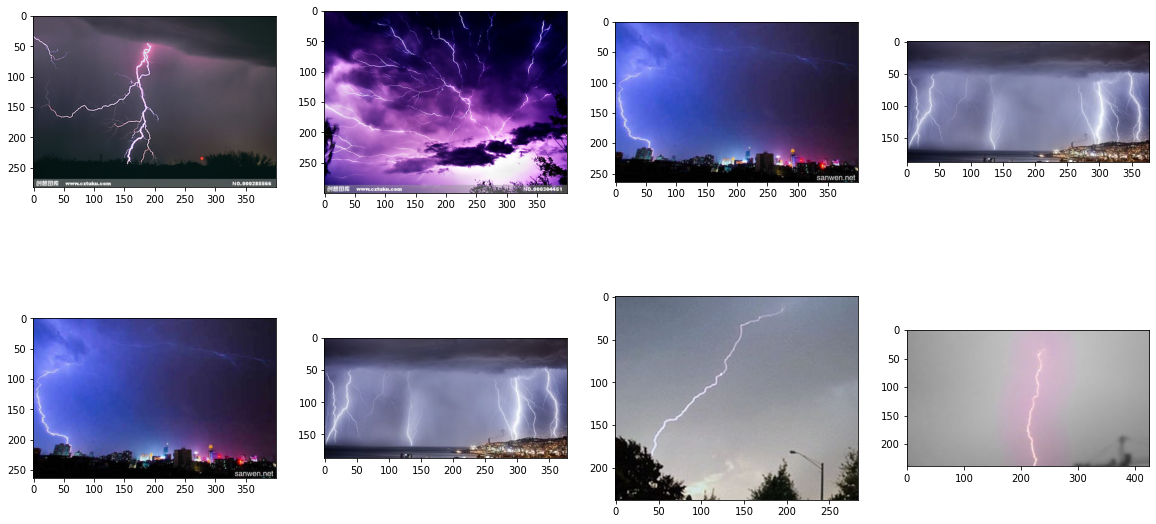

In [2]:
# read image
indx=0
images = [] 
y = []


# images are nested in subdirectories. The subdirectory an image is in represents 
idx = 0
for weather_subdir in os.listdir(IMAGE_PATH):
    weather_subdir_path = IMAGE_PATH + weather_subdir
    if (os.path.isdir(weather_subdir_path)):
        for img in os.listdir(weather_subdir_path):
            img_path = weather_subdir_path + '/' + img
            y.append(weather_subdir)
            img = load_img(img_path)
            images.append(img)
        

# print some sample images
nrows, ncols = 2,4 #print first 8 images
f, axs = plt.subplots(nrows, ncols, figsize=(20,10))
for i in range(nrows):
    for j in range(ncols):
        indx = i*nrows+j
        axs[i,j].imshow(images[indx])

In [3]:
# look at the various weather condiition and the number of samples we have for each weather type
print("Frequency by weather condition: " + str(Counter(y)))


Frequency by weather condition: Counter({'rime': 1160, 'fogsmog': 851, 'dew': 698, 'sandstorm': 692, 'glaze': 639, 'snow': 621, 'hail': 591, 'rain': 526, 'frost': 475, 'lightning': 377, 'rainbow': 232})


In [4]:
# note that the labels are still its class names rather than numerical. Transform `y`
class_to_numerical_label = {'lightning': 0,
         'sandstorm': 1,
         'glaze': 2,
         'rain': 3,
         'rime': 4,
         'frost': 5,
         'fogsmog': 6,
         'hail': 7,
         'dew': 8,
         'rainbow': 9,
         'snow': 10}
y_encoded = [class_to_numerical_label[weather] for weather in y]
print("Ferquency by weather condition label: " + str(Counter(y_encoded)))

Ferquency by weather condition label: Counter({4: 1160, 6: 851, 8: 698, 1: 692, 2: 639, 10: 621, 7: 591, 3: 526, 5: 475, 0: 377, 9: 232})


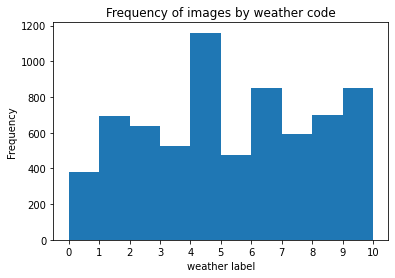

In [5]:
plt.hist(y_encoded)
plt.xticks(range(0, 11, 1))
plt.title("Frequency of images by weather code")
plt.ylabel("Frequency")
plt.xlabel("weather label")
plt.show()

In [6]:
def preprocess_data_part1(IMAGE_PATH, IMAGE_DIMENSION=(200,200), MAX_SAMPLE_SIZE_PER_CLASS = 400, random_seed = 1234):
    """ Generate lists of images and labelsbased on temp_no_refer and temp_refer lists
    
    Params:
    -------
    IMAGE_PATH (str): path to directory with images.
    IMAGE_DIMENSION (int, int): image resolution to resize images to
    MAX_SAMPLE_SIZE_PER_CLASS (int): the maximum number of samples to take for any single class
    
    
    Returns:
    --------
    images_mini  (np.ndarray): Images of shape (N, IMAGE_DIMENSION[0], IMAGE_DIMENSION[1], 3)
    y_mini (np.ndarray): Labels of shape (N,)    
    """
    np.random.seed(random_seed)
    y_mini = []
    images_mini = []

    # create lists of images and labels `images_mini` and `y_mini` 
    for weather_subdir in os.listdir(IMAGE_PATH):
        weather_subdir_path = IMAGE_PATH + weather_subdir
        imgs_for_weather_class = []
        if not (os.path.isdir(weather_subdir_path)):
            continue
        for img in os.listdir(weather_subdir_path):
            img_path = weather_subdir_path + '/' + img
            # read image
            img = load_img(img_path, target_size = IMAGE_DIMENSION)
            # transform to img to array
            img = img_to_array(img)
            # append to the images for this class
            imgs_for_weather_class.append(img)

        # sample the image if the count is larger than provided max size
        if (len(imgs_for_weather_class) > MAX_SAMPLE_SIZE_PER_CLASS):
            imgs_for_weather_class = random.sample(imgs_for_weather_class, MAX_SAMPLE_SIZE_PER_CLASS)
        # add the images for this weather class to images_mini
        images_mini.extend(imgs_for_weather_class)
        weather_label = class_to_numerical_label[weather_subdir]
        y_mini.extend([weather_label for i in range(len(imgs_for_weather_class))])
            

    # stack images and trasnform to array
    images_mini = np.stack(images_mini)
    y_mini = np.array(y_mini).flatten() 
    
    return images_mini, y_mini

In [7]:
# generate images and labels based on preprocess_data_part1() function
# TODO (SAVINAY) - feel free to alter the dataset 
images_mini, y_mini = preprocess_data_part1(IMAGE_PATH)

print(f"images_mini shape {images_mini.shape}")
print(f"y_mini shape {y_mini.shape}")

images_mini shape (4209, 200, 200, 3)
y_mini shape (4209,)


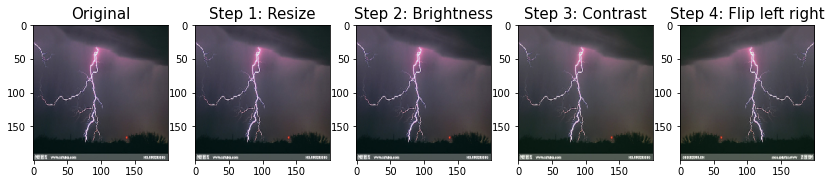

In [8]:
tf.random.set_seed(1234)

fig = plt.figure(figsize=(14, 12))

# pull first image from data
image = images_mini[0]

# plot original
ax = fig.add_subplot(1, 5, 1)
ax.imshow(array_to_img(image))
ax.set_title('Original', size=15);

# resize
ax = fig.add_subplot(1, 5, 2)
img_resize = tf.image.resize(image, size=(200, 200))
ax.imshow(array_to_img(img_resize))
ax.set_title('Step 1: Resize', size=15);


# adjust brightness
ax = fig.add_subplot(1, 5, 3)
img_bright = tf.image.adjust_brightness(img_resize, 0.3)
ax.imshow(array_to_img(img_bright))
ax.set_title('Step 2: Brightness', size=15);


# adjust contrast
ax = fig.add_subplot(1, 5, 4)
img_contrast = tf.image.adjust_contrast(img_bright, contrast_factor=3)
ax.imshow(array_to_img(img_contrast))
ax.set_title('Step 3: Contrast', size=15);


# flip left right
ax = fig.add_subplot(1, 5, 5)
img_flip = tf.image.flip_left_right(img_contrast)
ax.imshow(array_to_img(img_flip))
ax.set_title('Step 4: Flip left right', size=15);

In [22]:
IMAGE_SIZE = (200, 200)
CONTRAST_FACTOR = 3
DELTA = 0.3

def preprocess_data_part2(images, y, split=(0.6,0.2,0.2)):
    """ Split data into train, validation and test sets; apply transformaions and augmentations
    
    Params:
    -------
    images  (np.ndarray): Images of shape (N, 224, 224, 3)
    y (np.ndarray): Labels of shape (N,)   
    split (tuple): 3 values summing to 1 defining split of train, validation and test sets
    
    Returns:
    --------
    X_train (np.ndarray): Train images of shape (N_train, 224, 224, 3)
    y_train (np.ndarray): Train labels of shape (N_train,)
    X_val (np.ndarray): Val images of shape (N_val, 224, 224, 3)
    y_val (np.ndarray): Val labels of shape (N_val,)
    X_test (np.ndarray): Test images of shape (N_test, 224, 224, 3)
    y_test (np.ndarray): Test labels of shape (N_test,)
    
    """
    
    ### create train/validation/test sets ###
    #########################################
    # NOTE: Each time you run this cell, you'll re-shuffle the data. The ordering will be the same due to the random seed generator 
    tf.random.set_seed(1234)
    np.random.seed(1234)
    shuffle = np.random.permutation(np.arange(images.shape[0]))
    images, y = images[shuffle], y[shuffle]
    
    splits = np.multiply(len(images_mini), split).astype(int)
    X_train, X_val, X_test = np.split(images, [splits[0], splits[0]+splits[1]])
    y_train, y_val, y_test = np.split(y, [splits[0], splits[0]+splits[1]])
    
    ### image transformation on training, validation, and test data ###
    ###################################################################
    # image resize
    X_train = tf.image.resize(X_train, size=IMAGE_SIZE)
    X_val = tf.image.resize(X_val, size=IMAGE_SIZE)
    X_test = tf.image.resize(X_test, size=IMAGE_SIZE)
    
    # rescale image to [0,1], i.e., greyscale
    X_train = X_train/255.0
    X_val = X_val/255.0
    X_test = X_test/255.0
    
    
    ### image augmentation on training data ###
    ###########################################
    # adjust brightness
    X_train_augm = tf.image.adjust_brightness(X_train, delta=DELTA)
    
    # adjust contrast
    X_train_augm = tf.image.adjust_contrast(X_train_augm, contrast_factor=CONTRAST_FACTOR)

    # random flip
    X_train_augm = tf.image.random_flip_left_right(X_train_augm)
    
    # concatenate original X_train and augmented X_train data
    X_train = tf.concat([X_train, X_train_augm],axis=0)
    
    # concatenate y_train (note the label is preserved)
    y_train_augm = y_train
    y_train = tf.concat([y_train, y_train_augm],axis=0)
    
    # shuffle X_train and y_train, i.e., shuffle two tensors in the same order
    shuffle = tf.random.shuffle(tf.range(tf.shape(X_train)[0], dtype=tf.int32))
    X_train = tf.gather(X_train, shuffle)
    y_train = tf.gather(y_train, shuffle).numpy() #also transforms y_train to numpy array
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [23]:
X_train, y_train, X_val, y_val, X_test, y_test = preprocess_data_part2(
    images_mini,
    y_mini,
    split=(0.6,0.2,0.2)
)

print(f"X_train shape {X_train.shape}")
print(f"y_train shape {y_train.shape}")
print(f"X_val shape {X_val.shape}")
print(f"y_val shape {y_val.shape}")
print(f"X_test shape {X_test.shape}")
print(f"y_test shape {y_test.shape}")

X_train shape (5050, 200, 200, 3)
y_train shape (5050,)
X_val shape (841, 200, 200, 3)
y_val shape (841,)
X_test shape (843, 200, 200, 3)
y_test shape (843,)


In [27]:
np.unique(y_train)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [28]:
np.unique(y_val)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])